# Data Science Test - Victor Calderon

This is the results of analyzing the CMS patients data.

## Directions

This dataset contains a provider-level summary of inpatient discharges, average charges, and average Medicare payments for the top 100 Diagnosis-Related Groups (DRGs).

1. Which types of DRGs ("DRG.Definition") account for most of the patient population across all facilities?
2. For each facility ("Provider.Name"), which DRGs form the largest portion of the patient population?
3. Calculate the average Medicare payments per DRG per facility.
4. Is there a way to group facilities in a logical way?

---

The first thing to do is to load the modules, read in the data

### Loading Modules

In [1]:
# Importing modules
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.preprocessing import OneHotEncoder

# Sklearn imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


plt.rc('text', usetex=False)

### Reading in the data

I turned the dataset into a zipped pickle file because it was too large to host on Github.

In [2]:
# Path to data
filepath = '../data/CMS_Medicare_OpenSource_Data.zip'

# Reading in the data
df = pd.read_pickle(filepath, compression='zip')

Now we can visualize the data in order to better understand it

In [3]:
df.head(10)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44
5,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,67,$16920.79,$6653.80,$5374.14
6,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,51,$11977.13,$5834.74,$4761.41
7,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,32,$35841.09,$8031.12,$5858.50
8,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,AL - Huntsville,135,$28523.39,$6113.38,$5228.40
9,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10040,GADSDEN REGIONAL MEDICAL CENTER,1007 GOODYEAR AVENUE,GADSDEN,AL,35903,AL - Birmingham,34,$75233.38,$5541.05,$4386.94


The columns of the dataset are the following:

In [4]:
df.columns.tolist()

['DRG Definition',
 'Provider Id',
 'Provider Name',
 'Provider Street Address',
 'Provider City',
 'Provider State',
 'Provider Zip Code',
 'Hospital Referral Region Description',
 ' Total Discharges ',
 ' Average Covered Charges ',
 ' Average Total Payments ',
 'Average Medicare Payments']

In [5]:
print('>>> There are `{0}` rows and `{1}` columns'.format(*df.shape))

>>> There are `163065` rows and `12` columns


### Cleaning data

#### Whitespaces in columns

By taking a look at the columns, I'll remove any whitespaces from the column names and make the names lowercase.

In [6]:
df.rename(columns=dict([(x, '_'.join(x.split()).lower()) for x in df.columns.values]), inplace=True)
df.head()

,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


#### Odd symbols in columns

Removing `$` sign from or strings to make it easier to handle

In [7]:
for col_ii in ['average_covered_charges', 'average_total_payments', 'average_medicare_payments']:
    df.loc[:, col_ii] = df[col_ii].replace( '[\$,)]','', regex=True ).replace( '[(]','-',   regex=True ).astype(float)

### Miscellaneous

Throughout this analysis, I will be using only a few of the columns in the analysis.

In [8]:
drg_col      = 'drg_definition'
prov_col     = 'provider_name'
disch_col    = 'total_discharges'
medicare_col = 'average_medicare_payments'

---
## 1st Question

__Which types of DRGs ("DRG.Definition") account for most of the patient population across all facilities?__

To answer this question, one has to look at the `Total Discharges` for each type of DRGs.

In [9]:
print('There are `{0}` unique types of definitions'.format(df['drg_definition'].unique().shape[0]))

There are `100` unique types of definitions


In [10]:
# Number of top DRGs to choose
ntop = 15

## Computing the counts for DRGs in terms of total patient discharges and sorting them from highest to lowest
## I'm only showing the top 10 DRGs
drg_patient_top = df.loc[:, [drg_col, disch_col]].groupby(drg_col).count().sort_values(disch_col, ascending=False)
drg_patient_top.head(10)

,total_discharges
drg_definition,
194 - SIMPLE PNEUMONIA & PLEURISY W CC,3023
690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,2989
292 - HEART FAILURE & SHOCK W CC,2953
"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC",2950
"641 - MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/ELECTROLYTES W/O MCC",2899
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC,2812
603 - CELLULITIS W/O MCC,2807
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC,2750
191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,2720


Now I'll be plotting the number of total patient discharges per DRGs.

Text(0.5, 0, 'Total Discharges')

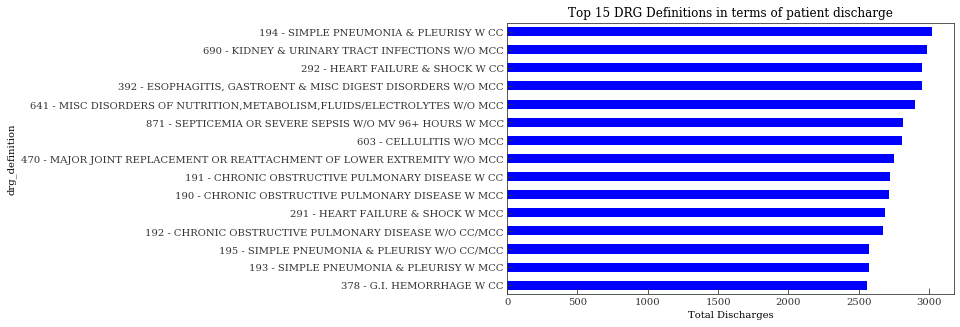

In [11]:
# Determining the top DRGs
ax_drg = drg_patient_top.head(ntop).sort_values(disch_col).plot(
    kind='barh', title='Top {0} DRG Definitions in terms of patient discharge'.format(ntop),
    legend=False, figsize=(8,5))

# Labels
ax_drg.set_xlabel('Total Discharges')

Another way to visualize this is looking at the `percentages` of the top DRGs

Text(0.5, 0, 'Percentage of total Discharges [%]')

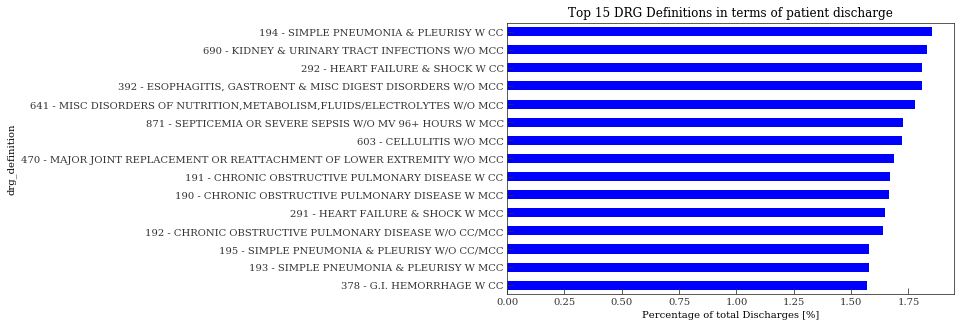

In [12]:
# Total percentage of the patient discharges for each DRG
drg_perc_col = 'perc_discharges'
drg_patient_top.loc[:, drg_perc_col] = 100 * (drg_patient_top[disch_col]/drg_patient_top[disch_col].sum())

ax_perc_drg = drg_patient_top[drg_perc_col].head(ntop).to_frame().sort_values(drg_perc_col).plot(
    kind='barh', title='Top 15 DRG Definitions in terms of patient discharge'.format(ntop),
    legend=False, figsize=(8,5))

# Labels
ax_perc_drg.set_xlabel('Percentage of total Discharges [%]')

---

## 2nd Question

__For each facility ("Provider.Name"), which DRGs form the largest portion of the patient population?__

In [13]:
# Selecting only certain column names
prov_main_df = df.loc[:, [prov_col, drg_col, disch_col]]
prov_main_df.head()

,provider_name,drg_definition,total_discharges
0,SOUTHEAST ALABAMA MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,91
1,MARSHALL MEDICAL CENTER SOUTH,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,14
2,ELIZA COFFEE MEMORIAL HOSPITAL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,24
3,ST VINCENT'S EAST,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,25
4,SHELBY BAPTIST MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,18


First, we need to figure out how many facilities there are

In [14]:
print('There are `{0}` unique facilities'.format(prov_main_df['provider_name'].unique().shape[0]))

There are `3201` unique facilities


There are __two__ ways to do this. 

The first one is to create a dictionary for each facility and determine the DRGs that contribute the most to the total discharges

- First, I'll save the data into a dictionary that can be easily accessed.
- Each entry will contain the DataFrames for each facility, sorted by most important DRG.

In [15]:
# Unique facilities
prov_unq = prov_main_df[prov_col].unique()

# Creating dictionary
prov_dict = {}

# Looping over facilities
for prov_ii in tqdm(prov_unq):
    prov_dict[prov_ii] = (prov_main_df.loc[prov_main_df[prov_col] == prov_ii]
                         .sort_values(by=disch_col, ascending=False)
                         .reset_index(drop=True)
                         .drop(prov_col, axis=1))

100%|██████████| 3201/3201 [00:39<00:00, 93.89it/s]


For example, `ABBEVILLE GENERAL HOSPITAL` suffers the most from `292 - HEART FAILURE & SHOCK W CC`

In [16]:
prov_dict['ABBEVILLE GENERAL HOSPITAL']

,drg_definition,total_discharges
0,292 - HEART FAILURE & SHOCK W CC,78
1,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,56
2,"641 - MISC DISORDERS OF NUTRITION,METABOLISM,F...",49
3,194 - SIMPLE PNEUMONIA & PLEURISY W CC,48
4,293 - HEART FAILURE & SHOCK W/O CC/MCC,38
5,291 - HEART FAILURE & SHOCK W MCC,36
6,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",29
7,603 - CELLULITIS W/O MCC,25
8,195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC,23
9,812 - RED BLOOD CELL DISORDERS W/O MCC,19


#### 2nd way

The 2nd way to look at these data is to choose the __top__ DRG for each facility.

In [17]:
# Initializing list to contain DataFrames
prov_grouped = [[] for x in range(prov_unq.shape[0])]

# Looping over all unique facilities
for ii, prov_ii in enumerate(tqdm(prov_unq)):
    prov_grouped[ii] = prov_dict[prov_ii].sort_values(disch_col, ascending=False).head(1)
    
# Concatenating list
prov_max_grouped = pd.concat(prov_grouped).reset_index(drop=True)

# Adding column of facilities
prov_max_grouped.loc[:, prov_col] = prov_unq

# Rearranging column order
prov_max_grouped = (prov_max_grouped[[prov_col, drg_col, disch_col]]
                   .sort_values(prov_col).reset_index(drop=True))

# Rename DRG column
prov_max_grouped.rename(columns={drg_col: 'Top_{0}'.format(drg_col)}, inplace=True)

100%|██████████| 3201/3201 [00:02<00:00, 1429.64it/s]


Now, the __TOP__ DRGs for each facility can be easily viewed:

In [18]:
prov_max_grouped

,provider_name,Top_drg_definition,total_discharges
0,ABBEVILLE GENERAL HOSPITAL,292 - HEART FAILURE & SHOCK W CC,78
1,ABBOTT NORTHWESTERN HOSPITAL,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,414
2,ABILENE REGIONAL MEDICAL CENTER,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,143
3,ABINGTON MEMORIAL HOSPITAL,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,331
4,ACMH HOSPITAL,885 - PSYCHOSES,63
5,ADCARE HOSPITAL OF WORCESTER INC,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,1571
6,ADENA REGIONAL MEDICAL CENTER,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,173
7,ADIRONDACK MEDICAL CENTER,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,94
8,ADVANCED SURGICAL HOSPITAL,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,71
9,ADVENTIST BOLINGBROOK HOSPITAL,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,115


---

## 3rd Question

__Calculate the average Medicare payments per DRG per facility.__

To determine the average Medicare payments per DRG per facility, we need to determine 

In [19]:
# Main Medicare DataFrame
medicare_main_df = df.loc[:, [prov_col, drg_col, medicare_col, disch_col]]
medicare_main_df.head(10)

,provider_name,drg_definition,average_medicare_payments,total_discharges
0,SOUTHEAST ALABAMA MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4763.73,91
1,MARSHALL MEDICAL CENTER SOUTH,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4976.71,14
2,ELIZA COFFEE MEMORIAL HOSPITAL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4453.79,24
3,ST VINCENT'S EAST,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4129.16,25
4,SHELBY BAPTIST MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4851.44,18
5,BAPTIST MEDICAL CENTER SOUTH,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,5374.14,67
6,EAST ALABAMA MEDICAL CENTER AND SNF,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4761.41,51
7,UNIVERSITY OF ALABAMA HOSPITAL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,5858.50,32
8,HUNTSVILLE HOSPITAL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,5228.40,135
9,GADSDEN REGIONAL MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,4386.94,34


We can now group the dataset based on the `provider_name` and `drg_definition` in order to know the `average_medicare_payments`:

In [20]:
# Grouping by DRG and facility
medicare_pd = (medicare_main_df.groupby([drg_col, prov_col])
              .mean()).drop(disch_col, axis=1)

Now, `medicare_pd` shows the average Medicare payment for each DRG and facility.

In [21]:
medicare_pd

average_medicare_payments
drg_definition                           provider_name                                                        
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC ABBOTT NORTHWESTERN HOSPITAL                                 5427.450
                                         ABILENE REGIONAL MEDICAL CENTER                              4695.540
                                         ABINGTON MEMORIAL HOSPITAL                                   5825.350
                                         ADENA REGIONAL MEDICAL CENTER                                5612.670
                                         ADVENTIST LA GRANGE MEMORIAL HOSPITAL                        5269.280
                                         ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER                    6691.850
                                         ADVOCATE CONDELL MEDICAL CENTER                              5303.940
                                         ADVOCATE GOOD SAMARITAN HOSPITAL                             4929.780
                                         ADVOCATE GOOD SHEPHERD HOSPITAL                              5307.660
                                         ADVOCATE LUTHERAN GENERAL HOSPITAL                           6437.520
                                         AIKEN REGIONAL MEDICAL CENTER                                5808.540
                                         AKRON GENERAL MEDICAL CENTER                                 5249.430
                                         ALAMANCE REGIONAL MEDICAL CENTER                             5174.360
                                         ALASKA REGIONAL HOSPITAL                                     6413.780
                                         ALBANY MEDICAL CENTER HOSPITAL                               6554.310
                                         ALBEMARLE HOSPITAL AUTHORITY                                 6036.400
                                         ALEGENT HEALTH BERGAN MERCY MEDICAL CENTER                   5193.670
                                         ALEGENT HEALTH IMMANUEL MEDICAL CENTER                       5602.090
                                         ALEXIAN BROTHERS MEDICAL CENTER                              4826.570
                                         ALLEGHENY GENERAL HOSPITAL                                   6399.150
                                         ALLEGIANCE HEALTH                                            4986.810
                                         ALLEN MEMORIAL HOSPITAL                                      4841.800
                                         ALPENA REGIONAL MEDICAL CENTER                               5995.340
                                         ALTOONA REGIONAL HEALTH SYSTEM                               4093.870
                                         ALTRU HOSPITAL                                               5920.760
                                         ALVARADO HOSPITAL MEDICAL CENTER                             6249.060
                                         ANDERSON REGIONAL MEDICAL CENTER                             4773.420
                                         ANMED HEALTH                                                 4700.170
                                         ANNE ARUNDEL MEDICAL CENTER                                  4726.690
                                         ANTELOPE VALLEY HOSPITAL MED CENTER                          6639.330
...                                                                                                        ...
948 - SIGNS & SYMPTOMS W/O MCC           WILLAMETTE VALLEY MEDICAL CENTER                             3513.830
                                         WILLIAM BEAUMONT HOSPITAL                                    4427.840
                                         WILLIAM BEAUMONT HOSPITAL-TROY                               3540.530
                                         WILLIAM N WISHARD MEMORIAL HOSPITAL             

---

## 4th Question

__Is there a way to group facilities in a logical way?__

There could be multiple answers to this question.
These are just a few different ways to group the different facitilies:

- By weighted DRGs at each facility
- Cost gap among facilities, i.e. facilities that charge signifcantly more for certain DRG than other facilities.
- Percentage of total revenue per DRG at each facility

I will try some of these approaches in the following sections

#### 4.1 - Weighted DRGs at each facility

The first step is determine the the weights of the different DRGs for each facility

In [22]:
# Selecting only certain column names
weighted_drgs_df = df.loc[:, [prov_col, drg_col, disch_col, medicare_col]]
weighted_drgs_df.head()

,provider_name,drg_definition,total_discharges,average_medicare_payments
0,SOUTHEAST ALABAMA MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,91,4763.73
1,MARSHALL MEDICAL CENTER SOUTH,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,14,4976.71
2,ELIZA COFFEE MEMORIAL HOSPITAL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,24,4453.79
3,ST VINCENT'S EAST,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,25,4129.16
4,SHELBY BAPTIST MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,18,4851.44


Now we can construct the DataFrame containing the `OneHotEncoder` columns:

In [23]:
# Creating encoded DataFrame
encoded_pd = pd.get_dummies(weighted_drgs_df, columns=[drg_col], prefix='enc', prefix_sep='_')
encoded_pd.head()

,provider_name,total_discharges,average_medicare_payments,enc_039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,enc_057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC,enc_064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W MCC,enc_065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W CC,enc_066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W/O CC/MCC,enc_069 - TRANSIENT ISCHEMIA,enc_074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC,...,enc_812 - RED BLOOD CELL DISORDERS W/O MCC,enc_853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC,enc_870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,enc_871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC,enc_872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W/O MCC,enc_885 - PSYCHOSES,enc_897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHABILITATION THERAPY W/O MCC,enc_917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,enc_918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,enc_948 - SIGNS & SYMPTOMS W/O MCC
0,SOUTHEAST ALABAMA MEDICAL CENTER,91,4763.73,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MARSHALL MEDICAL CENTER SOUTH,14,4976.71,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ELIZA COFFEE MEMORIAL HOSPITAL,24,4453.79,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ST VINCENT'S EAST,25,4129.16,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SHELBY BAPTIST MEDICAL CENTER,18,4851.44,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I have to create a function that determines the weight of each DRG at each facility:

In [24]:
# Function to determine the ranking and weights of each DRG at each facility
def drg_prov_calc(prov_group, weight_type='patient'):
    """
    Determines the ranking and weights of each DRG at each facility.
    
    Parameters
    -----------
    prov_group : `pandas.core.groups`
        Group for a given facility. It includes information about the types of DRGs performed at
        the facility, the total number of discharges, and the average medicare payments.
    
    weight_type : {`patient`, `medi`} `str`, optional
        Determines the type of weight to apply to the DataFrame. This variable is set
        to `patient` by default.
        
        Options:
            - `patient` : It uses the patients to obtain the weights of each DRG.
            - `medi` : It uses the total revenue from medicare to determine the weights of DRGs.
    
    Returns
    ---------
    wgh_drg_pd : `pandas.DataFrame`
        DataFrame containing information about the weighted DRGs for the given facility.
    """
    # Shortcuts for column names
    drg_col      = 'drg_definition'
    prov_col     = 'provider_name'
    disch_col    = 'total_discharges'
    medicare_col = 'average_medicare_payments'
    
    # Calculating weights for each DRG
    n_patients = prov_group[disch_col].sum()
    
    # Total amount of revenue generated
    n_medicare_drg_cost = prov_group[disch_col] * prov_group[medicare_col]
    n_medicare_total    = n_medicare_drg_cost.sum()
    
    # Selecting DRG columns
    drg_cols_enc = prov_group.columns[prov_group.columns.str.contains('enc_')]
    
    if (weight_type == 'patient'):
        # Computing the weighted DRG by total number of patients in facility
        wgh_drg_pd = (100.*((prov_group.loc[:, drg_cols_enc].multiply(prov_group[disch_col], axis=0)) / n_patients)
                      .sum(axis=0)
                      .to_frame()
                      .T)
    elif (weight_type == 'medi'):
        # Weighted DRG in terms of total cost
        wgh_drg_pd = (100.*((prov_group.loc[:, drg_cols_enc].multiply(n_medicare_drg_cost, axis=0)) / n_medicare_total)
                          .sum(axis=0)
                          .to_frame()
                          .T)
    
    return wgh_drg_pd

And we can now apply `drg_prov_calc` to each facility from `encoded_pd`:

In [25]:
# Computed weighted DRG for each facility
drg_prov_weight = encoded_pd.groupby(prov_col).apply(drg_prov_calc, ('patient'))

In [26]:
# Resetting indices
drg_prov_weight.reset_index(inplace=True)

# Dropping extra columns
drg_prov_weight.drop('level_1', axis=1, inplace=True)

We can look at some __clustering of facitilies__ in terms of DRGs.

One way to visualize it is via a __TSNE__:

In [27]:
start_time = time.time()

# Input data
input_data_cols = drg_prov_weight.columns[drg_prov_weight.columns.str.contains('enc_')]
tsne_input_data = drg_prov_weight.loc[:, input_data_cols].values

# Initializing TSNE element
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=0)

# Preparing input data
tsne_results = tsne.fit_transform(tsne_input_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - start_time))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3201 samples in 0.014s...
[t-SNE] Computed neighbors for 3201 samples in 1.875s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3201
[t-SNE] Computed conditional probabilities for sample 2000 / 3201
[t-SNE] Computed conditional probabilities for sample 3000 / 3201
[t-SNE] Computed conditional probabilities for sample 3201 / 3201
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.533035
[t-SNE] KL divergence after 1000 iterations: 1.682854
t-SNE done! Time elapsed: 44.70387601852417 seconds


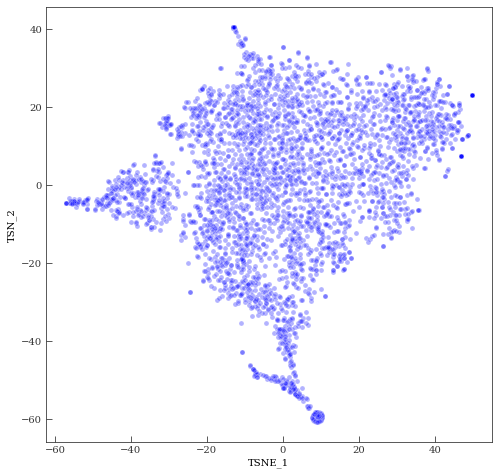

In [28]:
drg_prov_weight['TSNE_1'] = tsne_results[:,0]
drg_prov_weight['TSN_2'] = tsne_results[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="TSNE_1", y="TSN_2",
    palette=sns.color_palette("hls", 10),
    data=drg_prov_weight,
    legend="full",
    alpha=0.3
)

From this figure, one can see that there _might_ be different clusters of facilities when clustering
based on DRGs.

Or we can also use a __PCA__ for it:

In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tsne_input_data)
drg_prov_weight['pca-one'] = pca_result[:,0]
drg_prov_weight['pca-two'] = pca_result[:,1]

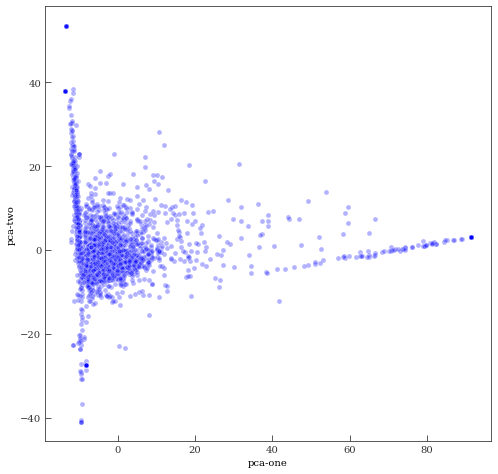

In [30]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=drg_prov_weight,
    legend="full",
    alpha=0.3
)

PCA __doesn't__ show any type of clusters for the different facilities though.

We can now test it based on the total Medicare cost per DRG at each facility.

In [31]:
# Computed weighted DRG for each facility
drg_prov_medi_weight = encoded_pd.groupby(prov_col).apply(drg_prov_calc, ('medi'))

# Resetting indices
drg_prov_medi_weight.reset_index(inplace=True)

# Dropping extra columns
drg_prov_medi_weight.drop('level_1', axis=1, inplace=True)

We can create the TSNE for this scenario:

In [32]:
start_time = time.time()

# Input data
input_data_cols = drg_prov_medi_weight.columns[drg_prov_medi_weight.columns.str.contains('enc_')]
tsne_input_medi_data = drg_prov_medi_weight.loc[:, input_data_cols].values

# Initializing TSNE element
tsne_medi = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=0)

# Preparing input data
tsne_medi_results = tsne_medi.fit_transform(tsne_input_medi_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - start_time))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3201 samples in 0.014s...
[t-SNE] Computed neighbors for 3201 samples in 1.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3201
[t-SNE] Computed conditional probabilities for sample 2000 / 3201
[t-SNE] Computed conditional probabilities for sample 3000 / 3201
[t-SNE] Computed conditional probabilities for sample 3201 / 3201
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.582451
[t-SNE] KL divergence after 1000 iterations: 1.514978
t-SNE done! Time elapsed: 35.539945125579834 seconds


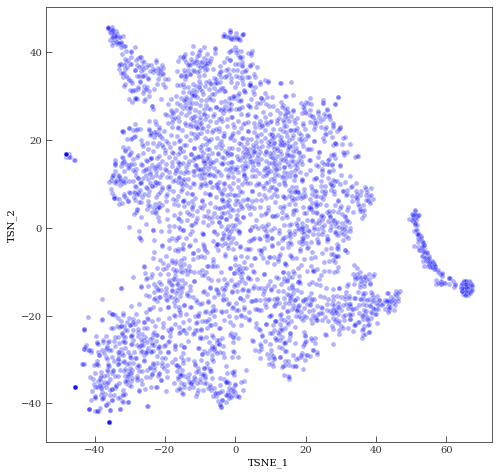

In [33]:
drg_prov_medi_weight['TSNE_1'] = tsne_medi_results[:,0]
drg_prov_medi_weight['TSN_2'] = tsne_medi_results[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="TSNE_1", y="TSN_2",
    palette=sns.color_palette("hls", 10),
    data=drg_prov_medi_weight,
    legend="full",
    alpha=0.3
)

This TSNE shows a some clustering among different facilities, but it is not trivial to determine them.

---